## Code produit avec l'article: 
https://medium.com/h7w/implementing-a-variational-autoencoder-with-keras-e19d7140ad90

### On compare deux façons de trier les données
#### Les couleurs ont été normalisées
#### on prédit uniquement sur un texel

In [151]:
from keras.layers import Conv1D, Conv2D, Input, Flatten, Dense, MaxPooling1D, MaxPooling2D, BatchNormalization, Concatenate
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.models import Model
import tensorflow as tf
from PIL import Image
import copy
import numpy as np
import keras
import os
import re



In [152]:
# Fonction pour calculer les coordonées stéréographiques

def stereo(theta, phi):
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    # Projection sur x y
    px = x / (1 + z + 1e-8)
    py = y / (1 + z + 1e-8)
    return px, py

# Importation des images

In [153]:
# Dossier contenant les images
repertoire = "../Render/captures"
img_width, img_height = 50, 50

# Expression pour extraire les infos du nom de fichier
#pattern = re.compile(r"img_tv(\d+)_pv(\d+)_tl(\d+)_pl(\d+)\.png") #all
pattern = re.compile(r"img_tv0_pv0_tl(\d+)_pl(\d+)\.jpg") #les images avec tv = 45 (la latitude moyenne)

# Stockage des résultats
images_info = []

for nom_fichier in os.listdir(repertoire):
    if nom_fichier.endswith(".jpg"):
        match = pattern.match(nom_fichier)
        if match:
            tl, pl = match.groups()
            tl, pl = int(tl), int(pl)
            px, py = stereo(np.radians(tl), np.radians(pl)) # Calcul des coordonnées stéréo
            chemin_image = os.path.join(repertoire, nom_fichier)
            image = Image.open(chemin_image)
            w, h = image.size
            left = (w - img_width) / 2
            top = (h - img_height) / 2
            right = (w + img_width) / 2
            bottom = (h + img_height) / 2
            #left, top, right, bottom = int(left), int(top), int(right), int(bottom)
            image = Image.open(chemin_image).crop((left, top, right, bottom))
            pixels = np.array(image, dtype=np.float32) / 255.0


            images_info.append({
                "tl": tl,
                "pl": pl,
                "px": px,
                "py": py,
                "image": image,
                "pixels": pixels,
            })

# Exemple : affichage d'une info
for info in images_info[:5]:  # juste les 5 premières
    print(f"tl={info['tl']}, pl={info['pl']}, px={info['px']}, py={info['py']}")

tl=75, pl=345, px=0.7411809490095723, py=-0.198598836732448
tl=75, pl=225, px=-0.5425821122771244, py=-0.5425821122771243
tl=60, pl=252, px=-0.17841104369713806, py=-0.5490927320369364
tl=30, pl=120, px=-0.13397459549759358, py=0.23205080632532074
tl=45, pl=160, px=-0.3892334257113643, py=0.14166938114040184


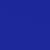

In [154]:
images_info[2]['image']

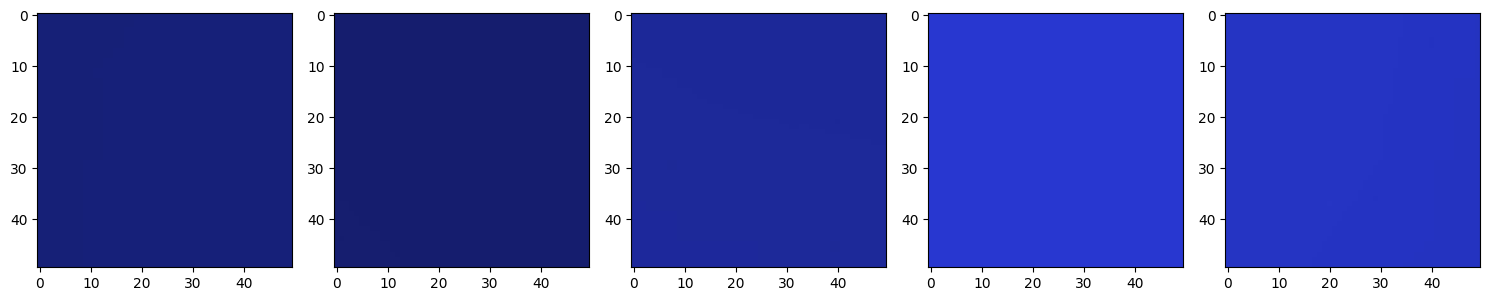

In [155]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(images_info[i]['pixels'])
plt.tight_layout()
plt.show()

# On trie la liste

In [156]:
sorted = copy.deepcopy(images_info)
sorted.sort(key=lambda d: (d["tl"], d["pl"]))

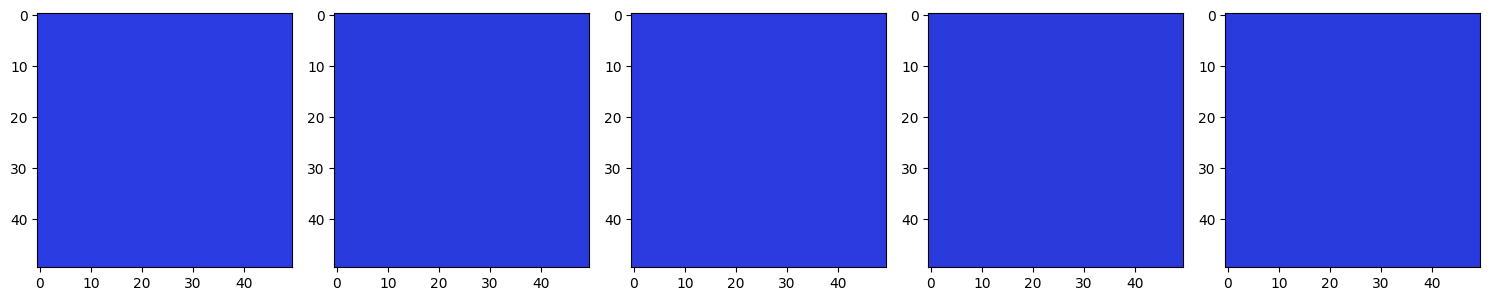

In [157]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5): axes[i].imshow(sorted[i]['pixels'])
plt.tight_layout()
plt.show()

# Cette fois ci visualisation de l'oraganisation des texels en fonctin des positions stéréo

In [158]:
# On prend le pixel le plus au centre
texel_row = img_height // 2
texel_col = img_width // 2
texel_position_str = f"({texel_row}, {texel_col})" # Pour l'affichage
print(texel_position_str)

(25, 25)


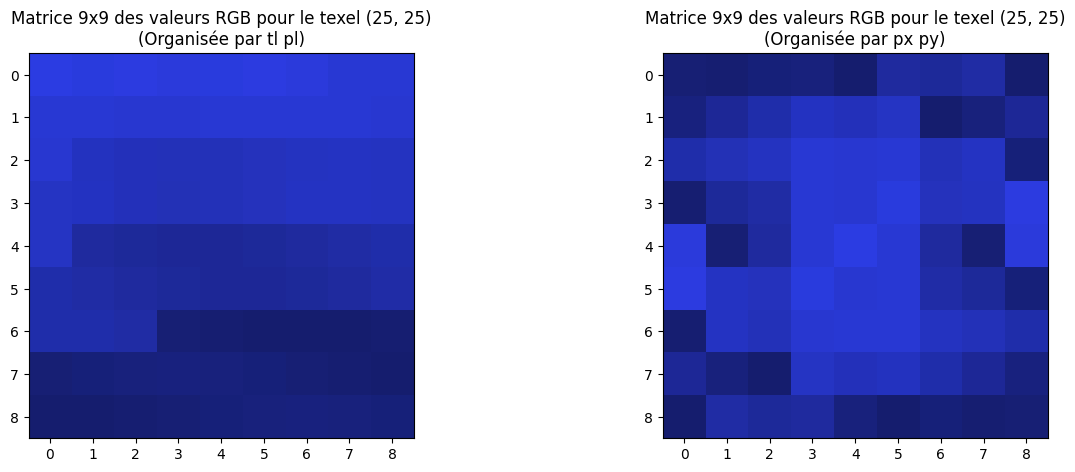

In [159]:
# Visualiser l'organisation de la matrice 9*9 en fonction du tri
# D'abord tl pl puis px, py
texel_angles = []
texel_stereo = []

images_angles = copy.deepcopy(images_info) # Copie pour le tri par angles
images_stereo = copy.deepcopy(images_info) # Copie pour le tri par stéréographiques


# Appliquer les tris aux copies distinctes
images_angles.sort(key=lambda d: (d["tl"], d["pl"]))
images_stereo.sort(key=lambda d: (d["px"], d["py"]))


for ang, ste in zip(images_angles, images_stereo):
    # info["pixels"] est le tableau NumPy 30x30x3 pour l'image entière de cette configuration angulaire
    texel_rgb_a = ang["pixels"][texel_row, texel_col, :]
    texel_rgb_s = ste["pixels"][texel_row, texel_col, :]
    texel_angles.append(texel_rgb_a)
    texel_stereo.append(texel_rgb_s)

# Convertir la liste en tableau NumPy
texel_angles_np = np.array(texel_angles, dtype=np.float32) # Forme (81, 3)
texel_stereo_np = np.array(texel_stereo, dtype=np.float32) # Forme (81, 3)

# Remodeler en matrice 9x9x3
mat_a = (texel_angles_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)
mat_s = (texel_stereo_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_a)
axes[1].imshow(mat_s)
axes[0].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par tl pl)")
axes[1].set_title(f"Matrice 9x9 des valeurs RGB pour le texel {texel_position_str}\n(Organisée par px py)")
plt.show()


In [160]:
images_info[0]['pixels'][0, 0], sorted[0]['pixels'][0, 0]

(array([0.08627451, 0.1254902 , 0.46666667], dtype=float32),
 array([0.16862746, 0.23529412, 0.8862745 ], dtype=float32))

In [161]:
print("Premier pixel de la troisième image (R,G,B) :", images_info[2]['pixels'][0][0])
print("Nombre d'images importées:", len(images_info))

Premier pixel de la troisième image (R,G,B) : [0.10980392 0.15686275 0.59607846]
Nombre d'images importées: 81


# Création du modèles

In [162]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light_ang = Model(inputs=i, outputs=latent_output, name="EncoderLight_ang")
#encoder_model_light_ang.summary()

# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input_ang = Input(shape=(input_dim,), name='decoder_input_ang')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input_ang)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model_ang = Model(inputs=decoder_input_ang, outputs=decoder_output, name="Decoder_ang")
#decoder_model_ang.summary()

# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light_ang(i)
decoder_input_ang = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model_ang(decoder_input_ang)

vae_ang = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE_ang')
vae_ang.summary()

Model: "VAE_ang"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight_ang    │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 10)        │          0 │ EncoderLight_ang… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_ang         │ (None, 3)         │     35,513 │ concatenate_9[0]… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [163]:
latent_dim = 8 # Dimension du bottleneck
num_channels = 3 # RGB
samples = len(images_info) # Nombre de configuration angulaires
matrix_H = 9
matrix_W = 9

input_shape = (matrix_H, matrix_W, num_channels)

# Definition
i = Input(shape=input_shape, name='encoder_input')

# Bloc 1 (Conv1D -> Conv2D, MaxPooling1D -> MaxPooling2D)
x = Conv2D(filters = 64, kernel_size=(3, 3), padding='same', activation='relu')(i)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# Projection
x = Flatten()(x)
latent_output = Dense(latent_dim, name='latent_output')(x)

# Modèle
encoder_model_light_ste = Model(inputs=i, outputs=latent_output, name="EncoderLight_ste")
#encoder_model_light_ste.summary()

# =================
# Decoder
# =================

# Paramètres
angle_dim = 2  # 2 pour lumière
input_dim = latent_dim + angle_dim  # 8 + 2 = 10

# Entrée
decoder_input_ste = Input(shape=(input_dim,), name='decoder_input_ste')

# 4 couches Fully Connected avec ReLU
x = Dense(106, activation='relu')(decoder_input_ste)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)
x = Dense(106, activation='relu')(x)

# Sortie RGB (3 valeurs)
decoder_output = Dense(3, activation='linear', name='rgb_output')(x)

# Modèle
decoder_model_ste = Model(inputs=decoder_input_ste, outputs=decoder_output, name="Decoder_ste")
#decoder_model_ste.summary()

# =================
# VAE
# =================
view_light_input = Input(shape=(angle_dim,), name='view_light_input')
latent_vector = encoder_model_light_ste(i)
decoder_input_ste = Concatenate()([latent_vector, view_light_input])
vae_outputs = decoder_model_ste(decoder_input_ste)

vae_ste = Model(inputs=[i, view_light_input], outputs=vae_outputs, name='VAE_ste')
vae_ste.summary()

Model: "VAE_ste"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 9, 9, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EncoderLight_ste    │ (None, 8)         │     10,248 │ encoder_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ view_light_input    │ (None, 2)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 10)        │          0 │ EncoderLight_ste… │
│ (Concatenate)       │                   │            │ view_light_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_ste         │ (None, 3)         │     35,513 │ concatenate_10[0… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 45,761 (178.75 KB)

 Trainable params: 45,633 (178.25 KB)

 Non-trainable params: 128 (512.00 B)

In [164]:
# --- L2 Loss ---
def custom_reconstruction_loss(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))


# Compilation et entraînement
## On vérifie quel tri des images est le plus efficace
Sur un seul texel 

In [165]:
# on prend toutes les images
image_stack_ang = np.stack([info["pixels"] for info in images_angles], axis=0)
image_stack_ste = np.stack([info["pixels"] for info in images_stereo], axis=0)
# image_stack.shape = (N_images, height, width, 3)

In [166]:
# on fait de même avec les angles
tl_stack_ang = np.stack([info["tl"] for info in images_angles], axis=0)
pl_stack_ang = np.stack([info["pl"] for info in images_angles], axis=0)

# et pour les positions stéréo
px_stack_ang = np.stack([info["px"] for info in images_angles], axis=0)
py_stack_ang = np.stack([info["py"] for info in images_angles], axis=0)

tl_stack_ste = np.stack([info["tl"] for info in images_stereo], axis=0)
pl_stack_ste = np.stack([info["pl"] for info in images_stereo], axis=0)

# et pour les positions stéréo
px_stack_ste = np.stack([info["px"] for info in images_stereo], axis=0)
py_stack_ste = np.stack([info["py"] for info in images_stereo], axis=0)

In [167]:
# Préparation des données

# Choisir UN texel
texel_position = (texel_row, texel_col)
texel_observations_ang = image_stack_ang[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations_ang = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations_ang[:len(texel_observations_ang)] = texel_observations_ang

input_train_batch_2d_ang = padded_observations_ang.reshape((1, matrix_H, matrix_W, num_channels)) # matrice input pour LE texel
target_rgb_train_ang = texel_observations_ang  # (81, 3)
light_dirs_ang = np.stack([px_stack_ang, py_stack_ang], axis=1) # Forme (81, 2)


texel_observations_ste = image_stack_ste[:, texel_position[0], texel_position[1]] # (samples, num_channels) ex: (81, 3)

padded_observations_ste = np.zeros((matrix_H * matrix_W, num_channels))
padded_observations_ste[:len(texel_observations_ste)] = texel_observations_ste

input_train_batch_2d_ste = padded_observations_ste.reshape((1, matrix_H, matrix_W, num_channels))
target_rgb_train_ste = texel_observations_ste  # (81, 3)
light_dirs_ste = np.stack([px_stack_ste, py_stack_ste], axis=1) # Forme (81, 2)

In [168]:
print(f"couleurs triées par les angles: {target_rgb_train_ang[0]}, par les coordonnées: {target_rgb_train_ste[0]}")

couleurs triées par les angles: [0.16862746 0.23529412 0.8862745 ], par les coordonnées: [0.09019608 0.12156863 0.45490196]


In [169]:
custom_optimizer_ang = Adam(learning_rate=0.01) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae_ang.compile(custom_optimizer_ang, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae_ang = vae_ang.fit([np.repeat(input_train_batch_2d_ang, samples, axis=0), light_dirs_ang], target_rgb_train_ang,
        epochs=50, batch_size=5, validation_split=0.2)

custom_optimizer_ste = Adam(learning_rate=0.01) # Adam est une version améliorée de la descente de gradient stochastique, par défaut on avait 0.001
vae_ste.compile(custom_optimizer_ste, loss=lambda y_true, y_pred: custom_reconstruction_loss(y_true, y_pred))

history_vae_ste = vae_ste.fit([np.repeat(input_train_batch_2d_ste, samples, axis=0), light_dirs_ste], target_rgb_train_ste,
        epochs=50, batch_size=5, validation_split=0.2)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 3.1786 - val_loss: 0.0703
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: 0.0371
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.0296
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0074 - val_loss: 0.0271
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0069 - val_loss: 0.0189
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0094 - val_loss: 0.0241
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0178
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0107
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0064 - val_loss: 0.0161
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0048 - val_loss: 0.0126
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0070 - val_loss: 0.0096
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0046 - val_l

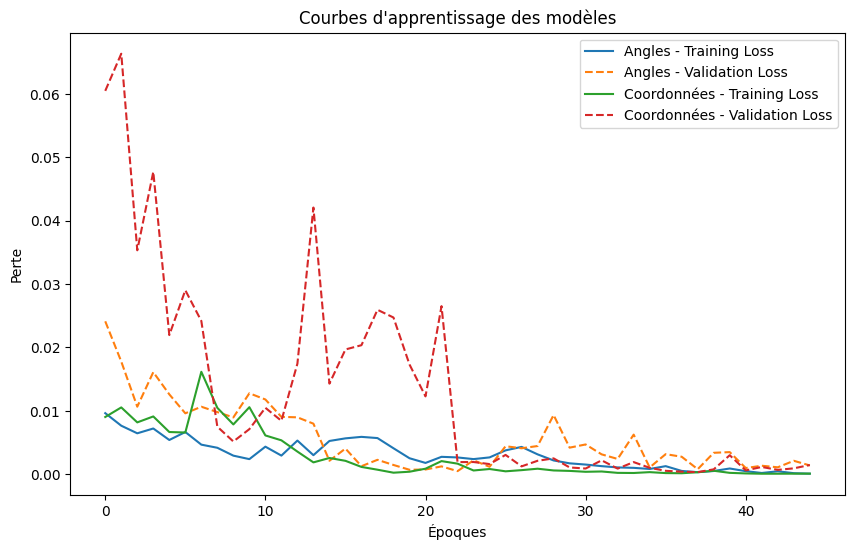

In [170]:
def plot_multiple_learning_curves(history_list, titles, start_epoch=0):
    plt.figure(figsize=(10, 6))
    for i, history in enumerate(history_list):
        model_title = titles[i]
        
        # Vérifiez que 'loss' et 'val_loss' sont présents
        plt.plot(history.history['loss'][start_epoch:], label=f"{model_title} - Training Loss")
        plt.plot(history.history['val_loss'][start_epoch:], label=f"{model_title} - Validation Loss", linestyle='--')

    plt.title("Courbes d'apprentissage des modèles")
    plt.xlabel("Époques")
    plt.ylabel("Perte")
    plt.legend()
    plt.show()

plot_multiple_learning_curves(
    history_list=[history_vae_ang, history_vae_ste],
    titles=["Angles", "Coordonnées"],
    start_epoch=5
)


# Prédicitions d'un texel avec une configuration spécifique

In [171]:
index = 3
light_direction = light_dirs_ang[index]

latent_vector = encoder_model_light_ang.predict(input_train_batch_2d_ang)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model_ang.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train_ang[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted RGB: [[0.1613066 0.231647  0.8468458]] Original [0.16862746 0.22745098 0.85882354]


In [172]:
index = 3
light_direction =light_dirs_ste[index]

latent_vector = encoder_model_light_ste.predict(input_train_batch_2d_ste)[0]  # (8,)

# Prédire pour une direction spécifique (par exemple view_light_train[0])
decoder_input = np.concatenate([latent_vector, light_direction])[np.newaxis, :]
predicted_rgb = decoder_model_ste.predict(decoder_input)  # (1, 3)
print("Predicted RGB:", predicted_rgb, "Original", target_rgb_train_ste[index])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted RGB: [[0.08912884 0.12169947 0.4591335 ]] Original [0.09411765 0.12941177 0.4862745 ]


# Compraison des prédictions visuellement

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


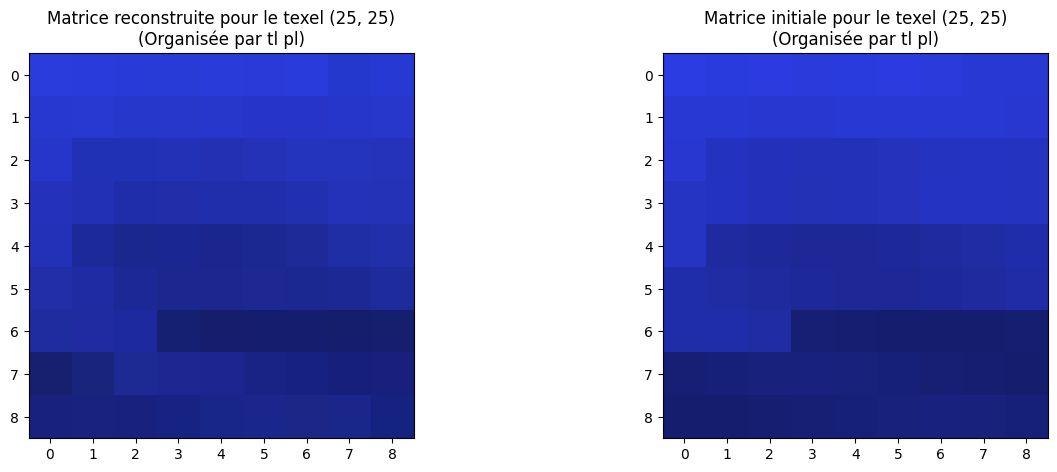

Différence absolue entre la matrice reconstruite, et la matrice initiale: 0.014


In [ ]:
light_dirs_ang
latent_vector = encoder_model_light_ang.predict(input_train_batch_2d_ang)[0]  # (8,) c'est le vecteur latent pour le texel étudié

predicted_rgb_ang = []

for angles in light_dirs_ang:
    decoder_input = np.concatenate([latent_vector, angles])[np.newaxis, :]
    predicted_rgb = decoder_model_ang.predict(decoder_input, verbose=0)  # (1, 3)
    predicted_rgb_ang.append(predicted_rgb)

predicted_rgb_ang_np = np.array(predicted_rgb_ang, dtype=np.float32) # Forme (81, 3)
mat_a_pred = (predicted_rgb_ang_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_a_pred)
axes[1].imshow(mat_a)
axes[0].set_title(f"Matrice reconstruite pour le texel {texel_position_str}\n(Organisée par tl pl)")
axes[1].set_title(f"Matrice initiale pour le texel {texel_position_str}\n(Organisée par tl pl)")
plt.show()

# On calcule la différence absolue
mse = np.mean(np.square(predicted_rgb_ang_np - texel_angles_np))
print(f"Différence absolue entre la matrice reconstruite, et la matrice initiale: {mse:.3f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


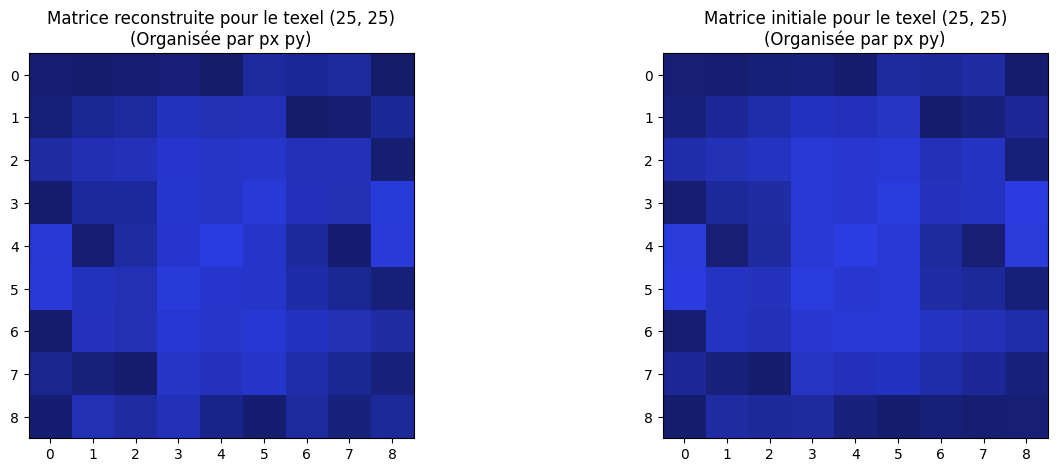

Différence absolue entre la matrice reconstruite, et la matrice initiale: 0.015


In [ ]:
light_dirs_ste
latent_vector = encoder_model_light_ste.predict(input_train_batch_2d_ste)[0]  # (8,) c'est le vecteur latent pour le texel étudié

predicted_rgb_ste = []

for angles in light_dirs_ste:
    decoder_input = np.concatenate([latent_vector, angles])[np.newaxis, :]
    predicted_rgb = decoder_model_ste.predict(decoder_input, verbose=0)  # (1, 3)
    predicted_rgb_ste.append(predicted_rgb)

predicted_rgb_ste_np = np.array(predicted_rgb_ste, dtype=np.float32) # Forme (81, 3)
mat_s_pred = (predicted_rgb_ste_np * 255.0).clip(0, 255).reshape((9, 9, 3)).astype(np.uint8)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].imshow(mat_s_pred)
axes[1].imshow(mat_s)
axes[0].set_title(f"Matrice reconstruite pour le texel {texel_position_str}\n(Organisée par px py)")
axes[1].set_title(f"Matrice initiale pour le texel {texel_position_str}\n(Organisée par px py)")
plt.show()

# On calcule la différence absolue
mse = np.mean(np.square(predicted_rgb_ste_np - texel_stereo_np))
print(f"Différence absolue entre la matrice reconstruite, et la matrice initiale: {mse:.3f}")